# Cross-Modality Correlation: 10x scRNA-seq vs MERFISH Receptor Expression

This notebook compares neuromodulator receptor expression between **10x single-nucleus
RNA sequencing** and **MERFISH spatial transcriptomics** data from the Allen Brain Cell
Atlas, for both the **basolateral amygdala (BLA)** and **medial prefrontal cortex (mPFC)**.

### Motivation
The two modalities measure gene expression differently:
- **10x snRNA-seq**: Whole-transcriptome (~32K genes), nuclear RNA, dissection-based regions
- **MERFISH**: Targeted panel (550 genes), whole-cell RNA, spatially resolved to CCF structures

Comparing them helps assess which receptor expression patterns are robust across
platforms and which cell-type rankings are most reliable for prioritizing experiments.

### Shared Genes (11 of 28 receptors)
- **Serotonin**: Htr1b, Htr1d, Htr2a, Htr3a, Htr7
- **Norepinephrine**: Adra1a, Adra1b
- **Dopamine**: Drd1, Drd2, Drd3, Drd5

### Key Caveat
- **BLA interneurons**: In 10x data, interneurons are CTXsp-wide (not BLA-exclusive).
  In MERFISH, they are spatially confirmed within BLA via CCF. Expect weaker
  correlations for BLA interneurons specifically.
- **mPFC**: Both modalities have region-specific filtering, so correlations should
  be stronger.

### Data
All data loaded from pre-extracted CSVs — no h5ad files needed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import re

## 1. Load Pre-Extracted CSVs

In [2]:
# BLA 10x
bla_10x_neur = pd.read_csv('bla_10x_neuronal_expression.csv', index_col=0)
bla_10x_glia = pd.read_csv('bla_10x_glia_expression.csv', index_col=0)
bla_10x_expr = pd.concat([bla_10x_neur, bla_10x_glia])
bla_10x_meta = pd.read_csv('bla_10x_metadata.csv', index_col=0)

# BLA MERFISH
bla_mer_expr = pd.read_csv('bla_merfish_expression.csv', index_col=0)
bla_mer_meta = pd.read_csv('bla_merfish_metadata.csv', index_col=0)

# mPFC 10x
mpfc_10x_neur = pd.read_csv('mpfc_receptor_expression.csv', index_col=0)
mpfc_10x_glia = pd.read_csv('mpfc_glia_receptor_expression.csv', index_col=0)
mpfc_10x_expr = pd.concat([mpfc_10x_neur, mpfc_10x_glia])
mpfc_10x_meta = pd.read_csv('mpfc_10x_metadata.csv', index_col=0)

# mPFC MERFISH
mpfc_mer_expr = pd.read_csv('mpfc_merfish_expression.csv', index_col=0)
mpfc_mer_meta = pd.read_csv('mpfc_merfish_metadata.csv', index_col=0)

print('Loaded datasets:')
print(f'  BLA 10x:    {len(bla_10x_expr):,} cells, {bla_10x_expr.shape[1]} genes')
print(f'  BLA MERFISH: {len(bla_mer_expr):,} cells, {bla_mer_expr.shape[1]} genes')
print(f'  mPFC 10x:   {len(mpfc_10x_expr):,} cells, {mpfc_10x_expr.shape[1]} genes')
print(f'  mPFC MERFISH: {len(mpfc_mer_expr):,} cells, {mpfc_mer_expr.shape[1]} genes')

Loaded datasets:
  BLA 10x:    54,113 cells, 28 genes
  BLA MERFISH: 8,238 cells, 11 genes
  mPFC 10x:   187,279 cells, 28 genes
  mPFC MERFISH: 64,474 cells, 11 genes


## 2. Compute Per-Subclass Summary Statistics

For each modality and region, compute:
- **Mean expression** (log2) per subclass per gene
- **Fraction expressing** (expression > 0) per subclass per gene

Then restrict to the 11 shared genes and shared subclasses.

In [3]:
# 11 shared receptor genes
shared_genes = ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7',
                'Adra1a', 'Adra1b',
                'Drd1', 'Drd2', 'Drd3', 'Drd5']

def strip_prefix(name):
    """Remove leading numeric prefix from taxonomy names."""
    return re.sub(r'^\d+\s+', '', str(name))

def compute_stats(expr_df, meta_df, genes):
    """Compute mean expression and fraction expressing per subclass."""
    # Align expression and metadata
    common = expr_df.index.intersection(meta_df.index)
    expr = expr_df.loc[common, genes].copy()
    meta = meta_df.loc[common].copy()
    meta['subclass_short'] = meta['subclass'].apply(strip_prefix)
    expr['subclass'] = meta['subclass_short'].values
    
    mean_expr = expr.groupby('subclass')[genes].mean()
    frac_expr = expr.groupby('subclass')[genes].apply(lambda x: (x > 0).mean())
    
    return mean_expr, frac_expr

# Compute stats for each dataset
bla_10x_mean, bla_10x_frac = compute_stats(bla_10x_expr, bla_10x_meta, shared_genes)
bla_mer_mean, bla_mer_frac = compute_stats(bla_mer_expr, bla_mer_meta, shared_genes)
mpfc_10x_mean, mpfc_10x_frac = compute_stats(mpfc_10x_expr, mpfc_10x_meta, shared_genes)
mpfc_mer_mean, mpfc_mer_frac = compute_stats(mpfc_mer_expr, mpfc_mer_meta, shared_genes)

print('Per-subclass stats computed:')
print(f'  BLA 10x:     {len(bla_10x_mean)} subclasses')
print(f'  BLA MERFISH:  {len(bla_mer_mean)} subclasses')
print(f'  mPFC 10x:    {len(mpfc_10x_mean)} subclasses')
print(f'  mPFC MERFISH: {len(mpfc_mer_mean)} subclasses')

Per-subclass stats computed:
  BLA 10x:     12 subclasses
  BLA MERFISH:  10 subclasses
  mPFC 10x:    20 subclasses
  mPFC MERFISH: 18 subclasses


In [4]:
# Find shared subclasses between modalities for each region
bla_shared_sc = sorted(set(bla_10x_mean.index) & set(bla_mer_mean.index))
mpfc_shared_sc = sorted(set(mpfc_10x_mean.index) & set(mpfc_mer_mean.index))

print(f'BLA shared subclasses ({len(bla_shared_sc)}):')
for sc in bla_shared_sc:
    print(f'  {sc}')

print(f'\nmPFC shared subclasses ({len(mpfc_shared_sc)}):')
for sc in mpfc_shared_sc:
    print(f'  {sc}')

# Align to shared subclasses
bla_10x_mean_s = bla_10x_mean.loc[bla_shared_sc]
bla_10x_frac_s = bla_10x_frac.loc[bla_shared_sc]
bla_mer_mean_s = bla_mer_mean.loc[bla_shared_sc]
bla_mer_frac_s = bla_mer_frac.loc[bla_shared_sc]

mpfc_10x_mean_s = mpfc_10x_mean.loc[mpfc_shared_sc]
mpfc_10x_frac_s = mpfc_10x_frac.loc[mpfc_shared_sc]
mpfc_mer_mean_s = mpfc_mer_mean.loc[mpfc_shared_sc]
mpfc_mer_frac_s = mpfc_mer_frac.loc[mpfc_shared_sc]

BLA shared subclasses (10):
  Astro-TE NN
  LA-BLA-BMA-PA Glut
  Lamp5 Gaba
  MEA-COA-BMA Ccdc42 Glut
  Microglia NN
  Pvalb Gaba
  Pvalb chandelier Gaba
  Sncg Gaba
  Sst Gaba
  Vip Gaba

mPFC shared subclasses (18):
  Astro-TE NN
  L2/3 IT CTX Glut
  L4/5 IT CTX Glut
  L5 ET CTX Glut
  L5 IT CTX Glut
  L5 NP CTX Glut
  L6 CT CTX Glut
  L6 IT CTX Glut
  L6b CTX Glut
  Lamp5 Gaba
  Lamp5 Lhx6 Gaba
  Microglia NN
  Pvalb Gaba
  Pvalb chandelier Gaba
  Sncg Gaba
  Sst Chodl Gaba
  Sst Gaba
  Vip Gaba


## 3. Overall Scatter: 10x vs MERFISH

Each point = one (gene × subclass) combination. We plot both mean expression
and fraction expressing.

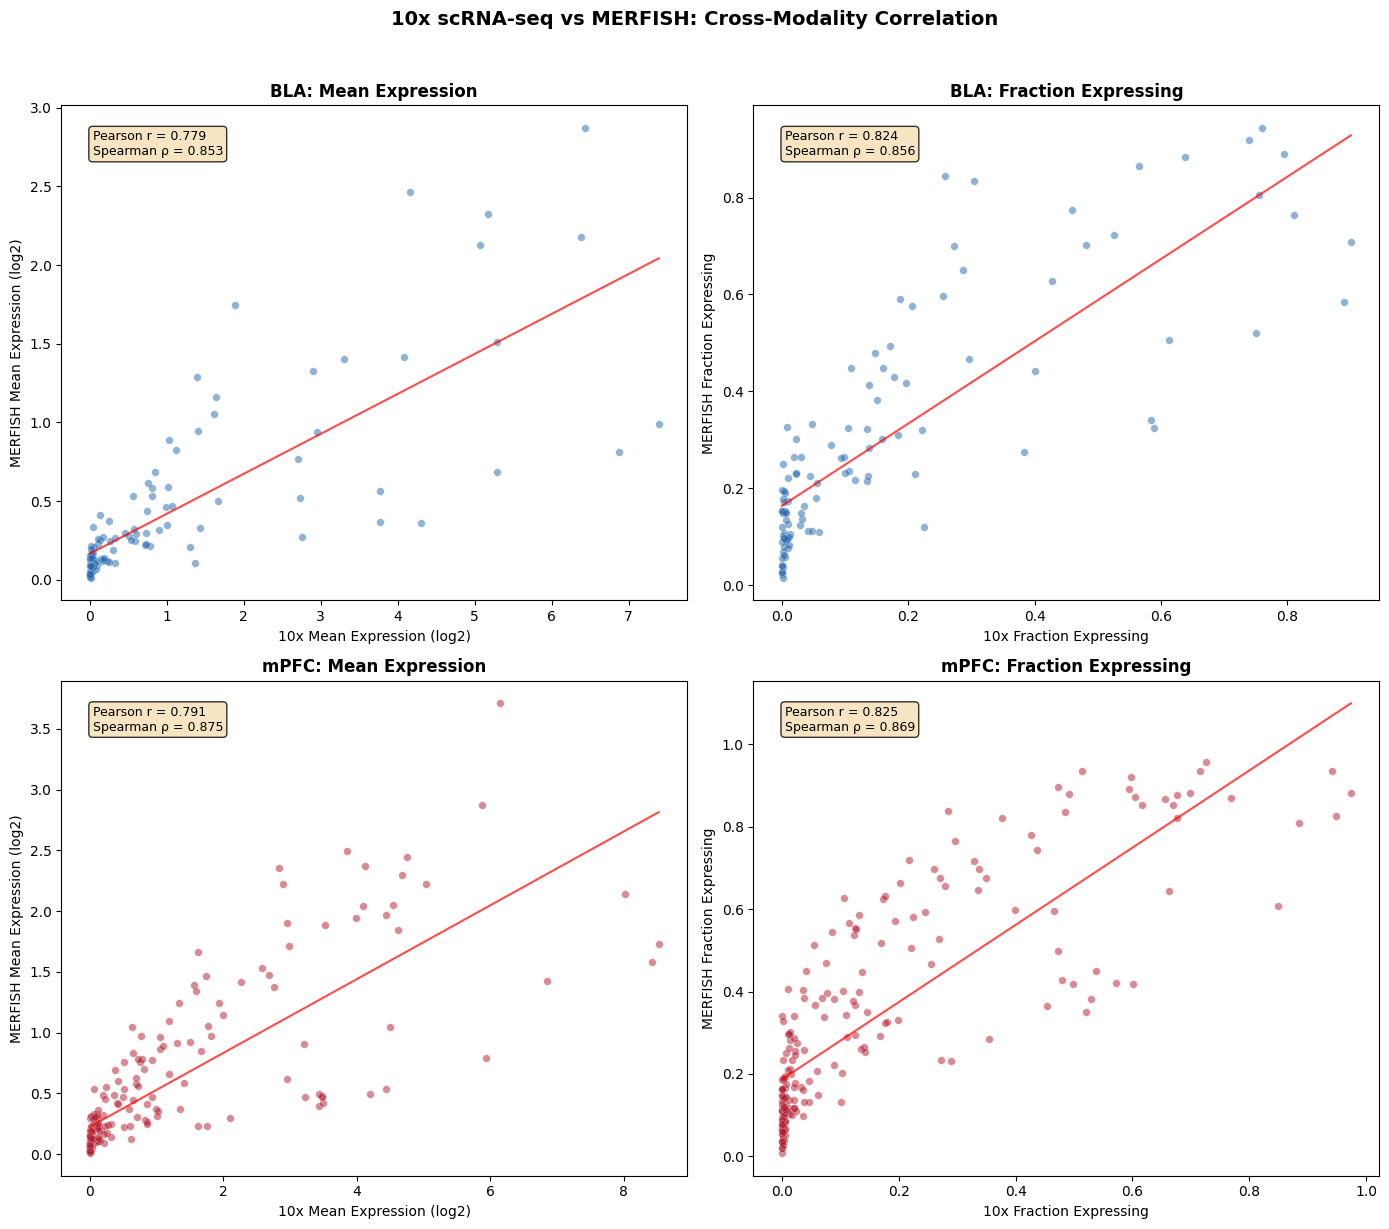

Saved: correlation_scatter_10x_vs_merfish.png


In [5]:
def scatter_correlation(ax, x, y, xlabel, ylabel, title, color='steelblue'):
    """Scatter plot with correlation stats."""
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    ax.scatter(x, y, alpha=0.5, s=30, c=color, edgecolors='white', linewidth=0.3)
    
    # Fit line
    if len(x) > 2:
        r_pearson, p_pearson = stats.pearsonr(x, y)
        r_spearman, p_spearman = stats.spearmanr(x, y)
        z = np.polyfit(x, y, 1)
        xline = np.linspace(x.min(), x.max(), 100)
        ax.plot(xline, np.polyval(z, xline), 'r-', alpha=0.7, linewidth=1.5)
        ax.text(0.05, 0.95, f'Pearson r = {r_pearson:.3f}\nSpearman ρ = {r_spearman:.3f}',
                transform=ax.transAxes, va='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontweight='bold')

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# BLA - Mean expression
scatter_correlation(axes[0, 0],
    bla_10x_mean_s.values.flatten(), bla_mer_mean_s.values.flatten(),
    '10x Mean Expression (log2)', 'MERFISH Mean Expression (log2)',
    'BLA: Mean Expression', color='#2166ac')

# BLA - Fraction expressing
scatter_correlation(axes[0, 1],
    bla_10x_frac_s.values.flatten(), bla_mer_frac_s.values.flatten(),
    '10x Fraction Expressing', 'MERFISH Fraction Expressing',
    'BLA: Fraction Expressing', color='#2166ac')

# mPFC - Mean expression
scatter_correlation(axes[1, 0],
    mpfc_10x_mean_s.values.flatten(), mpfc_mer_mean_s.values.flatten(),
    '10x Mean Expression (log2)', 'MERFISH Mean Expression (log2)',
    'mPFC: Mean Expression', color='#b2182b')

# mPFC - Fraction expressing
scatter_correlation(axes[1, 1],
    mpfc_10x_frac_s.values.flatten(), mpfc_mer_frac_s.values.flatten(),
    '10x Fraction Expressing', 'MERFISH Fraction Expressing',
    'mPFC: Fraction Expressing', color='#b2182b')

plt.suptitle('10x scRNA-seq vs MERFISH: Cross-Modality Correlation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('correlation_scatter_10x_vs_merfish.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: correlation_scatter_10x_vs_merfish.png')

## 4. Per-Gene Correlation

For each gene, compute the Spearman correlation of its expression across cell types
between 10x and MERFISH. This reveals which genes have the most consistent
cell-type profiles across platforms.

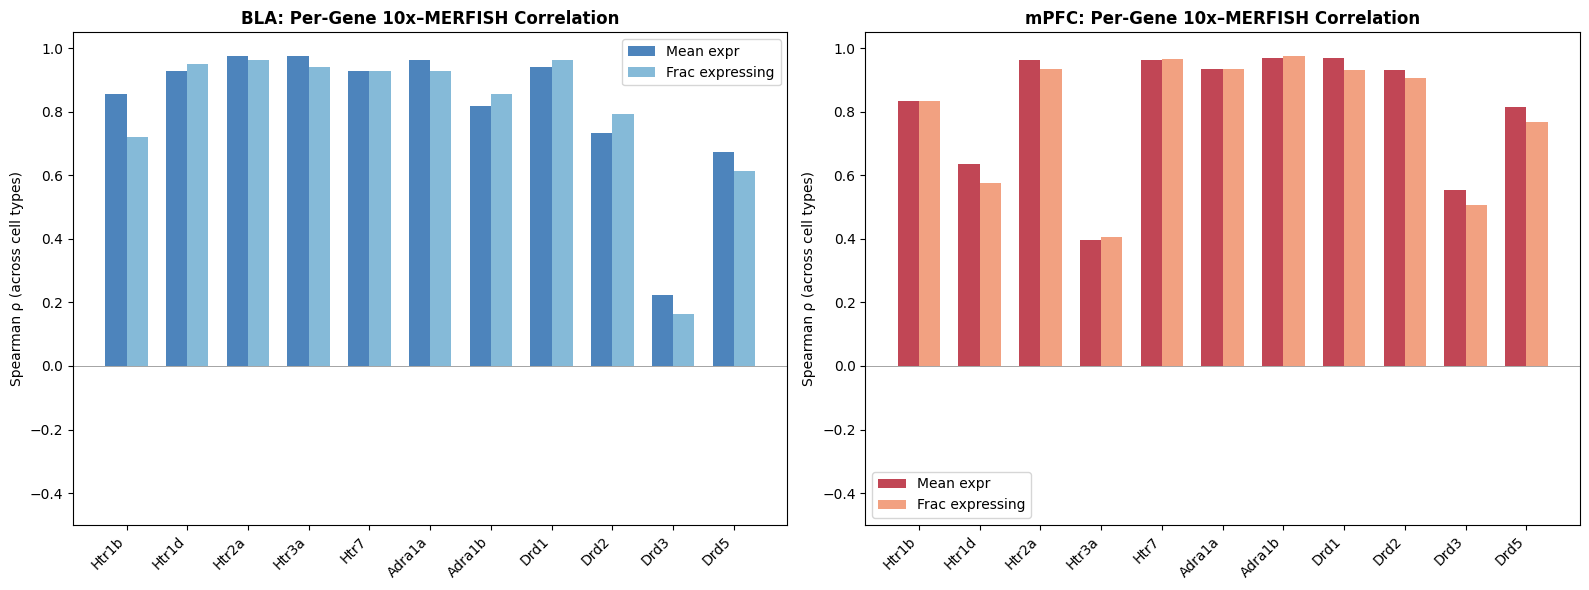

Saved: correlation_per_gene.png

BLA per-gene correlations:


,rho_mean,p_mean,rho_frac,p_frac
gene,,,,
Htr1b,0.855,0.002,0.721,0.019
Htr1d,0.927,0.000,0.952,0.000
Htr2a,0.976,0.000,0.964,0.000
Htr3a,0.976,0.000,0.939,0.000
Htr7,0.927,0.000,0.927,0.000
Adra1a,0.964,0.000,0.927,0.000
Adra1b,0.818,0.004,0.855,0.002
Drd1,0.939,0.000,0.964,0.000
Drd2,0.733,0.016,0.794,0.006



mPFC per-gene correlations:


,rho_mean,p_mean,rho_frac,p_frac
gene,,,,
Htr1b,0.833,0.000,0.833,0.000
Htr1d,0.637,0.004,0.577,0.012
Htr2a,0.963,0.000,0.934,0.000
Htr3a,0.397,0.103,0.406,0.095
Htr7,0.963,0.000,0.965,0.000
Adra1a,0.934,0.000,0.936,0.000
Adra1b,0.969,0.000,0.975,0.000
Drd1,0.969,0.000,0.932,0.000
Drd2,0.932,0.000,0.907,0.000


In [6]:
def per_gene_correlations(mean_10x, mean_mer, frac_10x, frac_mer, genes):
    """Compute per-gene Spearman correlations across cell types."""
    results = []
    for g in genes:
        r_mean, p_mean = stats.spearmanr(mean_10x[g], mean_mer[g])
        r_frac, p_frac = stats.spearmanr(frac_10x[g], frac_mer[g])
        results.append({'gene': g, 'rho_mean': r_mean, 'p_mean': p_mean,
                        'rho_frac': r_frac, 'p_frac': p_frac})
    return pd.DataFrame(results).set_index('gene')

bla_gene_corr = per_gene_correlations(bla_10x_mean_s, bla_mer_mean_s,
                                       bla_10x_frac_s, bla_mer_frac_s, shared_genes)
mpfc_gene_corr = per_gene_correlations(mpfc_10x_mean_s, mpfc_mer_mean_s,
                                        mpfc_10x_frac_s, mpfc_mer_frac_s, shared_genes)

# Plot per-gene correlations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(shared_genes))
width = 0.35

# BLA
axes[0].bar(x - width/2, bla_gene_corr['rho_mean'], width, label='Mean expr', color='#2166ac', alpha=0.8)
axes[0].bar(x + width/2, bla_gene_corr['rho_frac'], width, label='Frac expressing', color='#67a9cf', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(shared_genes, rotation=45, ha='right')
axes[0].set_ylabel('Spearman ρ (across cell types)')
axes[0].set_title('BLA: Per-Gene 10x–MERFISH Correlation', fontweight='bold')
axes[0].legend()
axes[0].axhline(y=0, color='grey', linewidth=0.5)
axes[0].set_ylim(-0.5, 1.05)

# mPFC
axes[1].bar(x - width/2, mpfc_gene_corr['rho_mean'], width, label='Mean expr', color='#b2182b', alpha=0.8)
axes[1].bar(x + width/2, mpfc_gene_corr['rho_frac'], width, label='Frac expressing', color='#ef8a62', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(shared_genes, rotation=45, ha='right')
axes[1].set_ylabel('Spearman ρ (across cell types)')
axes[1].set_title('mPFC: Per-Gene 10x–MERFISH Correlation', fontweight='bold')
axes[1].legend()
axes[1].axhline(y=0, color='grey', linewidth=0.5)
axes[1].set_ylim(-0.5, 1.05)

plt.tight_layout()
plt.savefig('correlation_per_gene.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: correlation_per_gene.png')

# Print tables
print('\nBLA per-gene correlations:')
display(bla_gene_corr.round(3))
print('\nmPFC per-gene correlations:')
display(mpfc_gene_corr.round(3))

## 5. Per-Cell-Type Correlation

For each cell type, compute the Spearman correlation of its receptor expression
profile (across the 11 genes) between 10x and MERFISH.

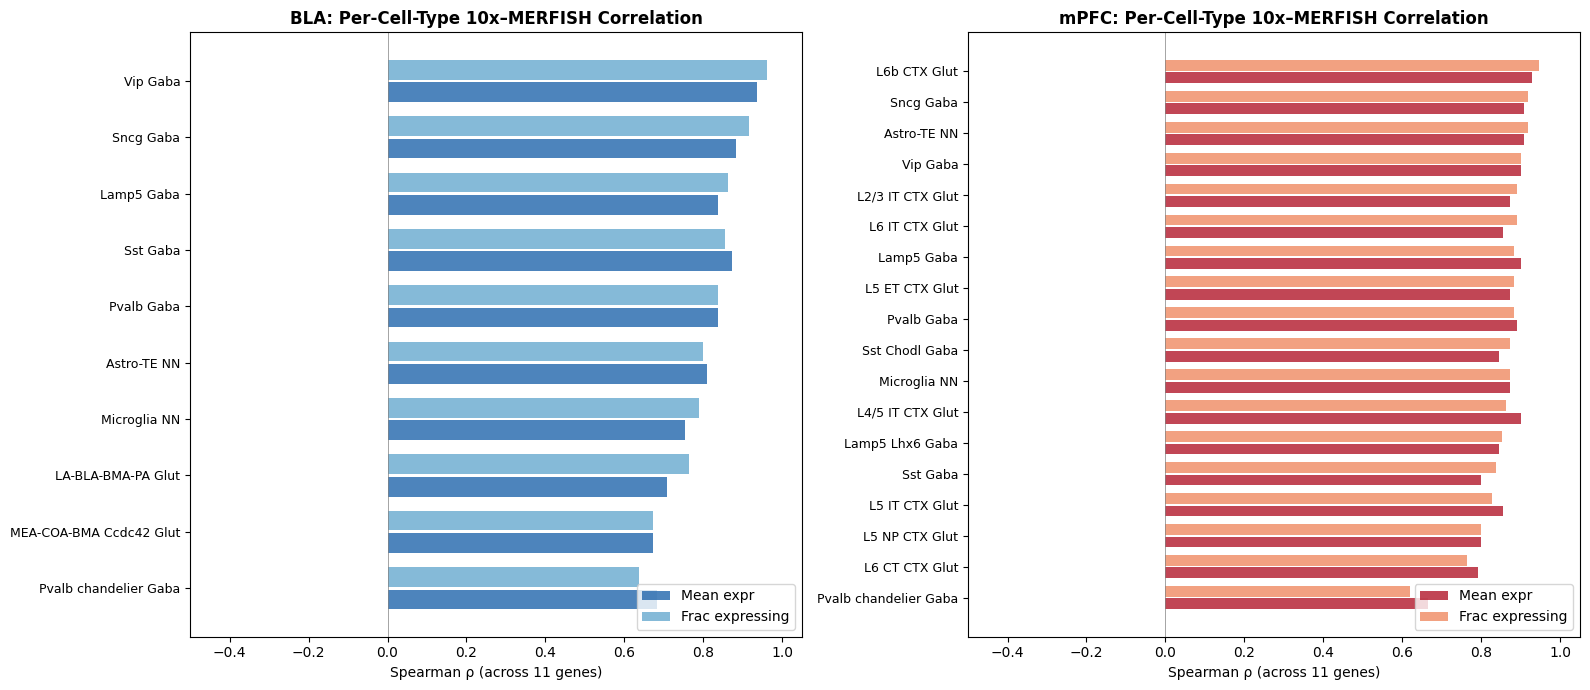

Saved: correlation_per_celltype.png

BLA per-cell-type correlations:


,rho_mean,p_mean,rho_frac,p_frac
subclass,,,,
Astro-TE NN,0.809,0.003,0.800,0.003
LA-BLA-BMA-PA Glut,0.709,0.015,0.764,0.006
Lamp5 Gaba,0.836,0.001,0.864,0.001
MEA-COA-BMA Ccdc42 Glut,0.673,0.023,0.673,0.023
Microglia NN,0.755,0.007,0.788,0.004
Pvalb Gaba,0.836,0.001,0.836,0.001
Pvalb chandelier Gaba,0.682,0.021,0.638,0.035
Sncg Gaba,0.882,0.000,0.916,0.000
Sst Gaba,0.873,0.000,0.855,0.001



mPFC per-cell-type correlations:


,rho_mean,p_mean,rho_frac,p_frac
subclass,,,,
Astro-TE NN,0.909,0.000,0.918,0.000
L2/3 IT CTX Glut,0.873,0.000,0.891,0.000
L4/5 IT CTX Glut,0.900,0.000,0.864,0.001
L5 ET CTX Glut,0.873,0.000,0.882,0.000
L5 IT CTX Glut,0.855,0.001,0.827,0.002
L5 NP CTX Glut,0.800,0.003,0.800,0.003
L6 CT CTX Glut,0.791,0.004,0.764,0.006
L6 IT CTX Glut,0.855,0.001,0.891,0.000
L6b CTX Glut,0.927,0.000,0.945,0.000


In [7]:
def per_celltype_correlations(mean_10x, mean_mer, frac_10x, frac_mer):
    """Compute per-cell-type Spearman correlations across genes."""
    results = []
    for sc in mean_10x.index:
        r_mean, p_mean = stats.spearmanr(mean_10x.loc[sc], mean_mer.loc[sc])
        r_frac, p_frac = stats.spearmanr(frac_10x.loc[sc], frac_mer.loc[sc])
        results.append({'subclass': sc, 'rho_mean': r_mean, 'p_mean': p_mean,
                        'rho_frac': r_frac, 'p_frac': p_frac})
    return pd.DataFrame(results).set_index('subclass')

bla_ct_corr = per_celltype_correlations(bla_10x_mean_s, bla_mer_mean_s,
                                         bla_10x_frac_s, bla_mer_frac_s)
mpfc_ct_corr = per_celltype_correlations(mpfc_10x_mean_s, mpfc_mer_mean_s,
                                          mpfc_10x_frac_s, mpfc_mer_frac_s)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# BLA
bla_ct_sorted = bla_ct_corr.sort_values('rho_frac', ascending=True)
y = np.arange(len(bla_ct_sorted))
axes[0].barh(y - 0.2, bla_ct_sorted['rho_mean'], 0.35, label='Mean expr', color='#2166ac', alpha=0.8)
axes[0].barh(y + 0.2, bla_ct_sorted['rho_frac'], 0.35, label='Frac expressing', color='#67a9cf', alpha=0.8)
axes[0].set_yticks(y)
axes[0].set_yticklabels(bla_ct_sorted.index, fontsize=9)
axes[0].set_xlabel('Spearman ρ (across 11 genes)')
axes[0].set_title('BLA: Per-Cell-Type 10x–MERFISH Correlation', fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].axvline(x=0, color='grey', linewidth=0.5)
axes[0].set_xlim(-0.5, 1.05)

# mPFC
mpfc_ct_sorted = mpfc_ct_corr.sort_values('rho_frac', ascending=True)
y = np.arange(len(mpfc_ct_sorted))
axes[1].barh(y - 0.2, mpfc_ct_sorted['rho_mean'], 0.35, label='Mean expr', color='#b2182b', alpha=0.8)
axes[1].barh(y + 0.2, mpfc_ct_sorted['rho_frac'], 0.35, label='Frac expressing', color='#ef8a62', alpha=0.8)
axes[1].set_yticks(y)
axes[1].set_yticklabels(mpfc_ct_sorted.index, fontsize=9)
axes[1].set_xlabel('Spearman ρ (across 11 genes)')
axes[1].set_title('mPFC: Per-Cell-Type 10x–MERFISH Correlation', fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].axvline(x=0, color='grey', linewidth=0.5)
axes[1].set_xlim(-0.5, 1.05)

plt.tight_layout()
plt.savefig('correlation_per_celltype.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: correlation_per_celltype.png')

print('\nBLA per-cell-type correlations:')
display(bla_ct_corr.round(3))
print('\nmPFC per-cell-type correlations:')
display(mpfc_ct_corr.round(3))

## 6. Receptor Rankings by Cell Type

For each gene, rank the cell types from highest to lowest expression (using
fraction expressing, which is more robust across platforms). Display the
rankings side-by-side for 10x vs MERFISH to identify concordant and
discordant patterns.

This is the key output for prioritizing experiments: genes where the
cell-type rankings agree across platforms are the most reliable targets.

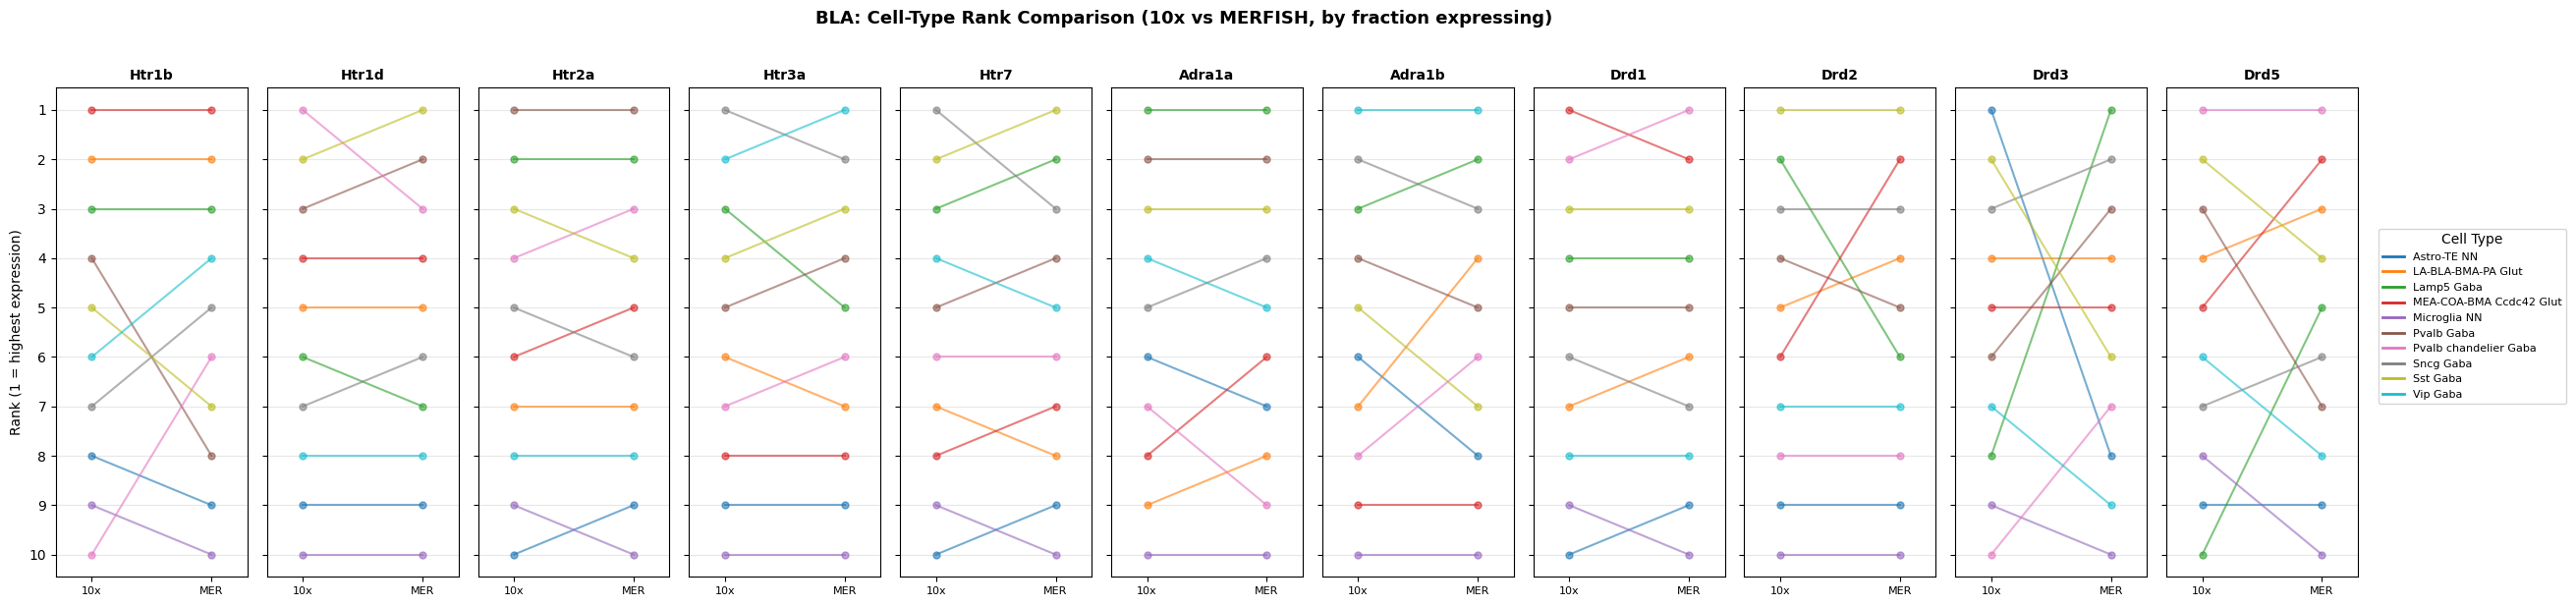

Saved: rank_comparison_BLA.png


In [8]:
def compute_ranks(frac_df):
    """Rank cell types per gene (1 = highest expression). Ties get average rank."""
    return frac_df.rank(ascending=False, method='average')

def plot_rank_comparison(frac_10x, frac_mer, shared_sc, genes, region, filename):
    """Bump chart showing cell-type ranks per gene for both modalities."""
    ranks_10x = compute_ranks(frac_10x.loc[shared_sc])
    ranks_mer = compute_ranks(frac_mer.loc[shared_sc])
    
    n_genes = len(genes)
    n_ct = len(shared_sc)
    
    fig, axes = plt.subplots(1, n_genes, figsize=(n_genes * 2.2, max(6, n_ct * 0.45)),
                             sharey=True)
    
    # Color map for cell types
    cmap = plt.cm.tab20
    colors = {sc: cmap(i / n_ct) for i, sc in enumerate(shared_sc)}
    
    for gi, gene in enumerate(genes):
        ax = axes[gi]
        
        for sc in shared_sc:
            r10x = ranks_10x.loc[sc, gene]
            rmer = ranks_mer.loc[sc, gene]
            
            # Draw line connecting 10x rank to MERFISH rank
            ax.plot([0, 1], [r10x, rmer], color=colors[sc], alpha=0.6,
                    linewidth=1.5, marker='o', markersize=5)
        
        ax.set_xlim(-0.3, 1.3)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['10x', 'MER'], fontsize=8)
        ax.set_title(gene, fontsize=10, fontweight='bold')
        ax.invert_yaxis()
        
        if gi == 0:
            ax.set_ylabel('Rank (1 = highest expression)')
            ax.set_yticks(range(1, n_ct + 1))
        
        ax.grid(axis='y', alpha=0.3)
    
    # Legend
    handles = [plt.Line2D([0], [0], color=colors[sc], linewidth=2, label=sc)
               for sc in shared_sc]
    fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1.0, 0.5),
               fontsize=8, title='Cell Type')
    
    plt.suptitle(f'{region}: Cell-Type Rank Comparison (10x vs MERFISH, by fraction expressing)',
                 fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filename}')
    
    return ranks_10x, ranks_mer

bla_ranks_10x, bla_ranks_mer = plot_rank_comparison(
    bla_10x_frac_s, bla_mer_frac_s, bla_shared_sc, shared_genes, 'BLA',
    'rank_comparison_BLA.png')

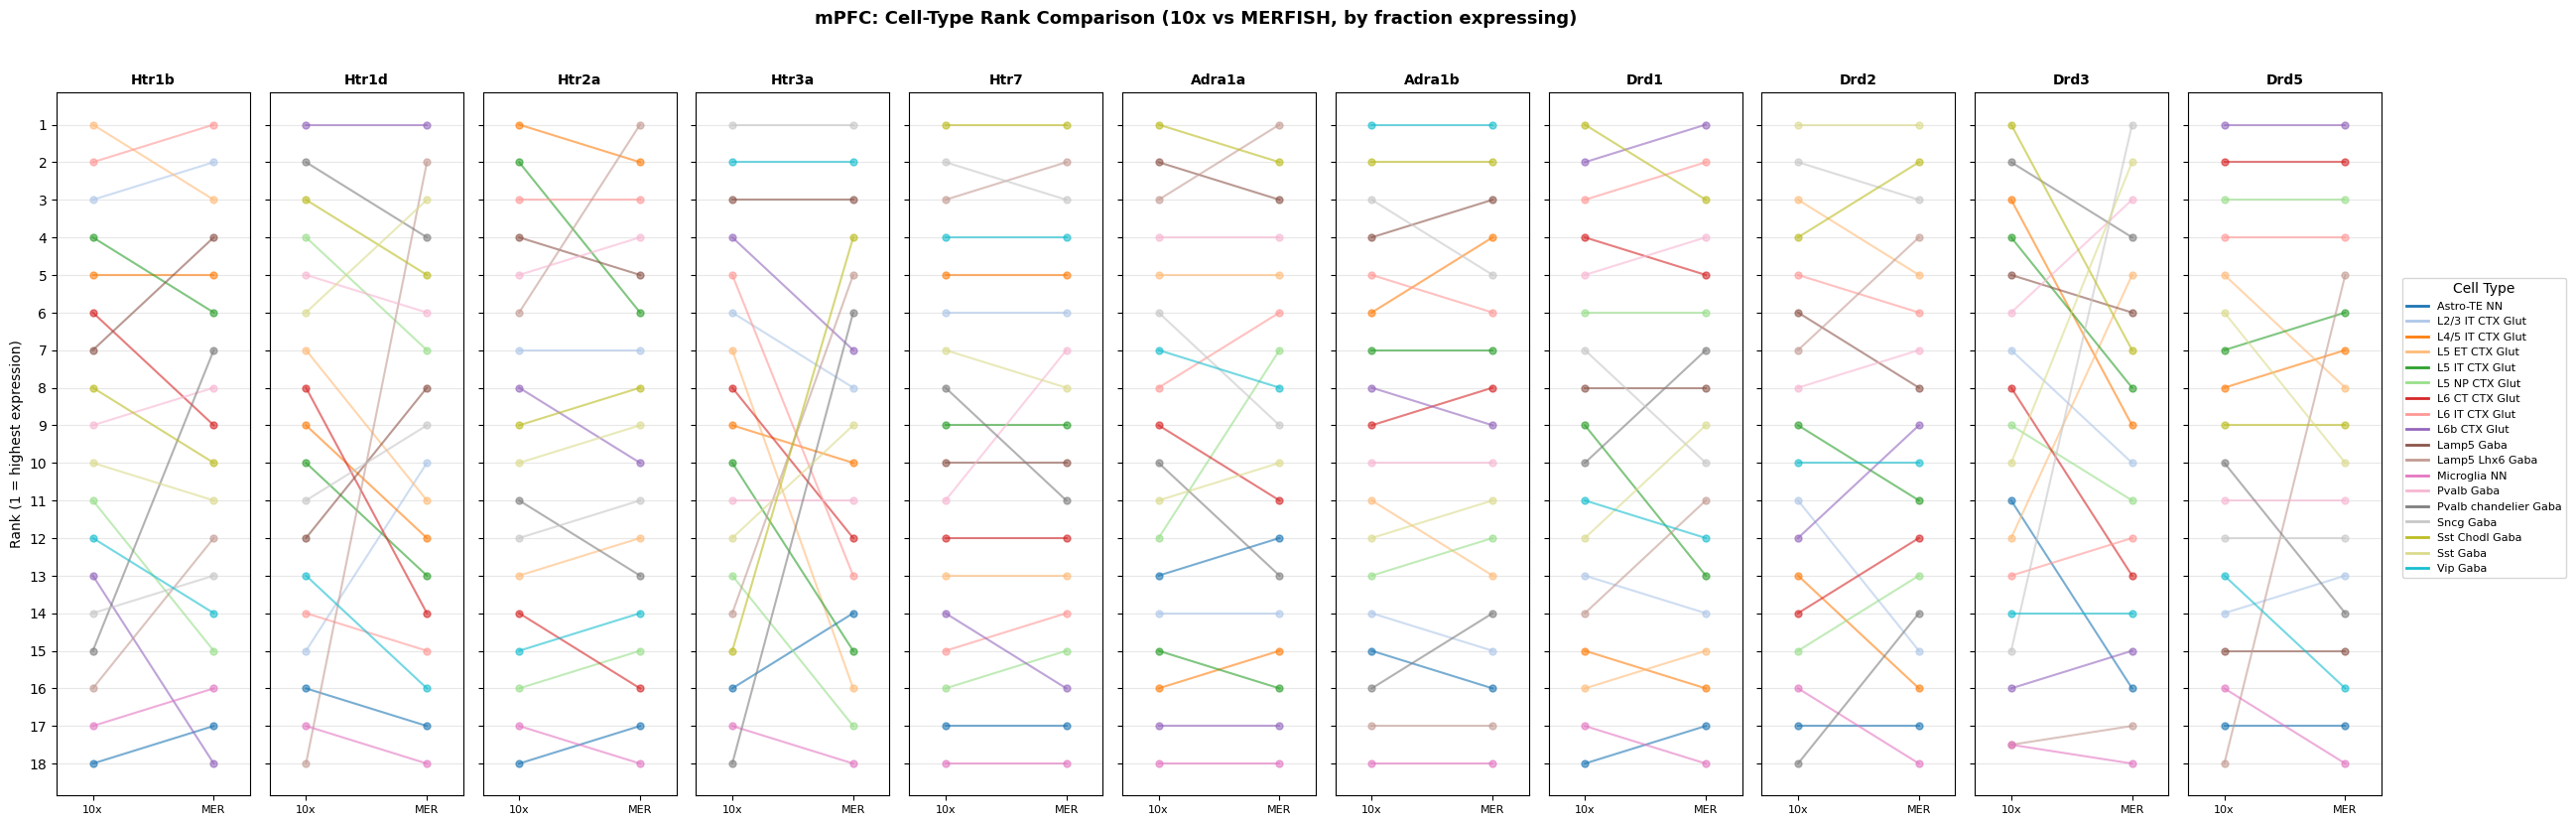

Saved: rank_comparison_mPFC.png


In [9]:
mpfc_ranks_10x, mpfc_ranks_mer = plot_rank_comparison(
    mpfc_10x_frac_s, mpfc_mer_frac_s, mpfc_shared_sc, shared_genes, 'mPFC',
    'rank_comparison_mPFC.png')

## 7. Rank Agreement Heatmap

For each gene × cell type, compute the rank difference (|10x rank - MERFISH rank|).
Small differences (green) = high agreement; large differences (red) = discordance.

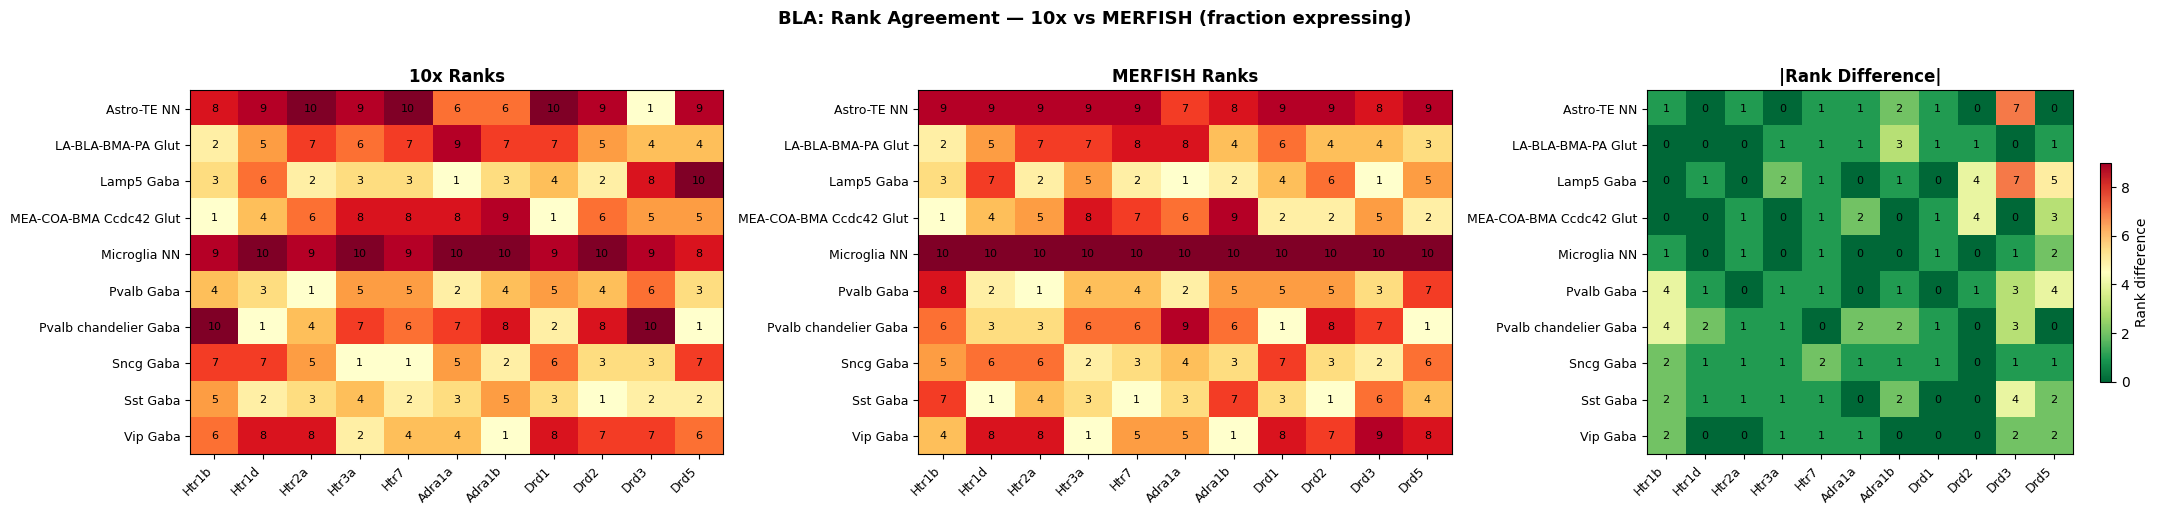

Saved: rank_agreement_BLA.png


In [10]:
def plot_rank_agreement_heatmap(ranks_10x, ranks_mer, genes, region, filename):
    """Heatmap of rank differences between modalities."""
    rank_diff = (ranks_10x[genes] - ranks_mer[genes]).abs()
    
    fig, axes = plt.subplots(1, 3, figsize=(22, max(5, len(rank_diff) * 0.45)),
                             gridspec_kw={'width_ratios': [1, 1, 1]})
    
    # Left: 10x ranks
    im1 = axes[0].imshow(ranks_10x[genes].values, cmap='YlOrRd', aspect='auto',
                          vmin=1, vmax=len(rank_diff))
    axes[0].set_title('10x Ranks', fontweight='bold')
    axes[0].set_yticks(range(len(rank_diff)))
    axes[0].set_yticklabels(rank_diff.index, fontsize=9)
    axes[0].set_xticks(range(len(genes)))
    axes[0].set_xticklabels(genes, rotation=45, ha='right', fontsize=9)
    # Annotate with rank numbers
    for i in range(len(rank_diff)):
        for j in range(len(genes)):
            axes[0].text(j, i, f'{int(ranks_10x[genes].iloc[i, j])}',
                        ha='center', va='center', fontsize=8, color='black')
    
    # Middle: MERFISH ranks
    im2 = axes[1].imshow(ranks_mer[genes].values, cmap='YlOrRd', aspect='auto',
                          vmin=1, vmax=len(rank_diff))
    axes[1].set_title('MERFISH Ranks', fontweight='bold')
    axes[1].set_yticks(range(len(rank_diff)))
    axes[1].set_yticklabels(rank_diff.index, fontsize=9)
    axes[1].set_xticks(range(len(genes)))
    axes[1].set_xticklabels(genes, rotation=45, ha='right', fontsize=9)
    for i in range(len(rank_diff)):
        for j in range(len(genes)):
            axes[1].text(j, i, f'{int(ranks_mer[genes].iloc[i, j])}',
                        ha='center', va='center', fontsize=8, color='black')
    
    # Right: Rank difference (agreement)
    im3 = axes[2].imshow(rank_diff.values, cmap='RdYlGn_r', aspect='auto',
                          vmin=0, vmax=len(rank_diff) - 1)
    axes[2].set_title('|Rank Difference|', fontweight='bold')
    axes[2].set_yticks(range(len(rank_diff)))
    axes[2].set_yticklabels(rank_diff.index, fontsize=9)
    axes[2].set_xticks(range(len(genes)))
    axes[2].set_xticklabels(genes, rotation=45, ha='right', fontsize=9)
    for i in range(len(rank_diff)):
        for j in range(len(genes)):
            axes[2].text(j, i, f'{int(rank_diff.iloc[i, j])}',
                        ha='center', va='center', fontsize=8, color='black')
    
    plt.colorbar(im3, ax=axes[2], shrink=0.6, label='Rank difference')
    
    plt.suptitle(f'{region}: Rank Agreement — 10x vs MERFISH (fraction expressing)',
                 fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filename}')
    
    return rank_diff

bla_rank_diff = plot_rank_agreement_heatmap(
    bla_ranks_10x, bla_ranks_mer, shared_genes, 'BLA',
    'rank_agreement_BLA.png')

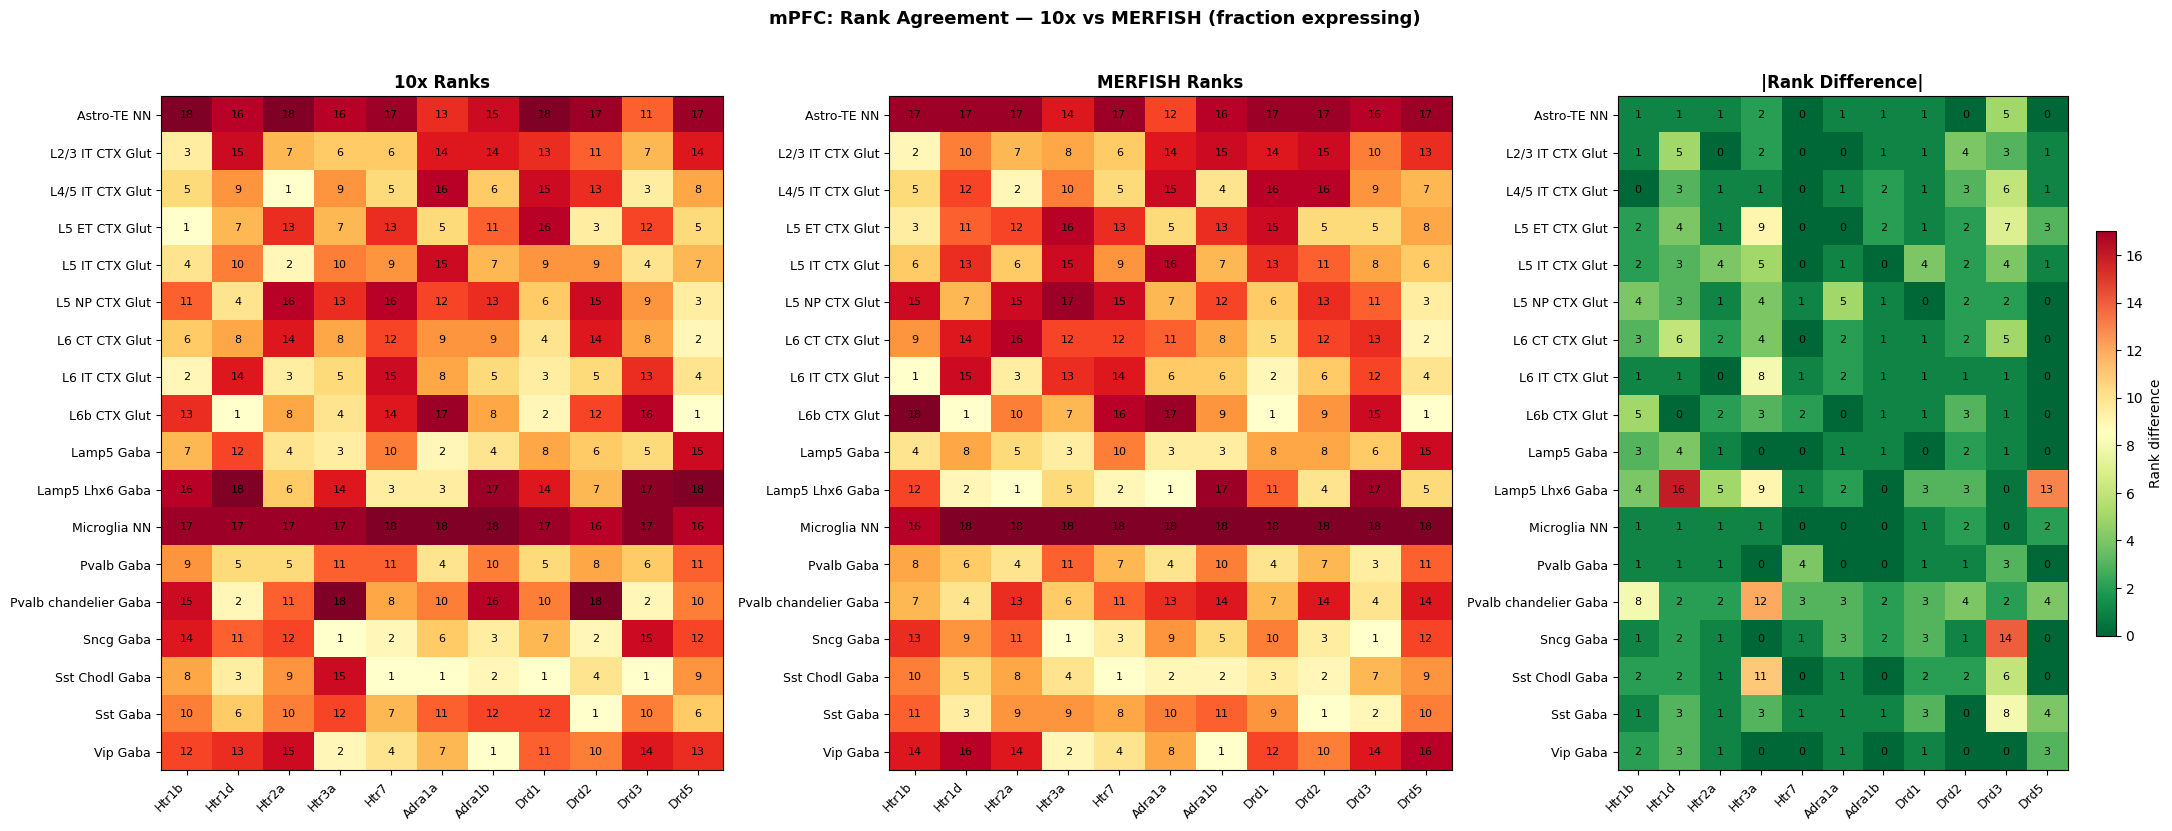

Saved: rank_agreement_mPFC.png


In [11]:
mpfc_rank_diff = plot_rank_agreement_heatmap(
    mpfc_ranks_10x, mpfc_ranks_mer, shared_genes, 'mPFC',
    'rank_agreement_mPFC.png')

## 8. Consensus Rankings

Average the ranks across both modalities to produce a single consensus ranking
per gene per cell type. Also compute a confidence score based on rank agreement
(lower rank difference = higher confidence).

In [12]:
def consensus_rankings(ranks_10x, ranks_mer, rank_diff, genes, shared_sc, region):
    """Compute consensus rank and confidence for each gene × cell type."""
    consensus = (ranks_10x[genes] + ranks_mer[genes]) / 2
    n_ct = len(shared_sc)
    # Confidence: 1 - (rank_diff / max_possible_diff)
    max_diff = n_ct - 1
    confidence = 1 - (rank_diff[genes] / max_diff)
    
    # Build summary table per gene: top cell types with consensus rank + confidence
    print(f'\n{"=" * 80}')
    print(f'{region}: Consensus Rankings (averaged 10x + MERFISH)')
    print(f'{"=" * 80}')
    
    summary_rows = []
    for gene in genes:
        gene_consensus = consensus[gene].sort_values()
        gene_confidence = confidence[gene]
        
        print(f'\n{gene}:')
        for rank_pos, (ct, cons_rank) in enumerate(gene_consensus.items(), 1):
            conf = gene_confidence[ct]
            r10x = int(ranks_10x.loc[ct, gene])
            rmer = int(ranks_mer.loc[ct, gene])
            conf_str = '***' if conf >= 0.8 else '** ' if conf >= 0.6 else '*  ' if conf >= 0.4 else '   '
            print(f'  {rank_pos:2d}. {ct:<30s}  consensus={cons_rank:.1f}  '
                  f'(10x={r10x}, MER={rmer})  confidence={conf:.2f} {conf_str}')
            summary_rows.append({
                'region': region, 'gene': gene, 'cell_type': ct,
                'consensus_rank': cons_rank,
                'rank_10x': r10x, 'rank_merfish': rmer,
                'rank_diff': abs(r10x - rmer),
                'confidence': conf
            })
    
    return pd.DataFrame(summary_rows), consensus, confidence

bla_summary, bla_consensus, bla_confidence = consensus_rankings(
    bla_ranks_10x, bla_ranks_mer, bla_rank_diff, shared_genes, bla_shared_sc, 'BLA')


BLA: Consensus Rankings (averaged 10x + MERFISH)

Htr1b:
   1. MEA-COA-BMA Ccdc42 Glut         consensus=1.0  (10x=1, MER=1)  confidence=1.00 ***
   2. LA-BLA-BMA-PA Glut              consensus=2.0  (10x=2, MER=2)  confidence=1.00 ***
   3. Lamp5 Gaba                      consensus=3.0  (10x=3, MER=3)  confidence=1.00 ***
   4. Vip Gaba                        consensus=5.0  (10x=6, MER=4)  confidence=0.78 ** 
   5. Sncg Gaba                       consensus=6.0  (10x=7, MER=5)  confidence=0.78 ** 
   6. Pvalb Gaba                      consensus=6.0  (10x=4, MER=8)  confidence=0.56 *  
   7. Sst Gaba                        consensus=6.0  (10x=5, MER=7)  confidence=0.78 ** 
   8. Pvalb chandelier Gaba           consensus=8.0  (10x=10, MER=6)  confidence=0.56 *  
   9. Astro-TE NN                     consensus=8.5  (10x=8, MER=9)  confidence=0.89 ***
  10. Microglia NN                    consensus=9.5  (10x=9, MER=10)  confidence=0.89 ***

Htr1d:
   1. Sst Gaba                        cons

In [13]:
mpfc_summary, mpfc_consensus, mpfc_confidence = consensus_rankings(
    mpfc_ranks_10x, mpfc_ranks_mer, mpfc_rank_diff, shared_genes, mpfc_shared_sc, 'mPFC')


mPFC: Consensus Rankings (averaged 10x + MERFISH)

Htr1b:
   1. L6 IT CTX Glut                  consensus=1.5  (10x=2, MER=1)  confidence=0.94 ***
   2. L5 ET CTX Glut                  consensus=2.0  (10x=1, MER=3)  confidence=0.88 ***
   3. L2/3 IT CTX Glut                consensus=2.5  (10x=3, MER=2)  confidence=0.94 ***
   4. L4/5 IT CTX Glut                consensus=5.0  (10x=5, MER=5)  confidence=1.00 ***
   5. L5 IT CTX Glut                  consensus=5.0  (10x=4, MER=6)  confidence=0.88 ***
   6. Lamp5 Gaba                      consensus=5.5  (10x=7, MER=4)  confidence=0.82 ***
   7. L6 CT CTX Glut                  consensus=7.5  (10x=6, MER=9)  confidence=0.82 ***
   8. Pvalb Gaba                      consensus=8.5  (10x=9, MER=8)  confidence=0.94 ***
   9. Sst Chodl Gaba                  consensus=9.0  (10x=8, MER=10)  confidence=0.88 ***
  10. Sst Gaba                        consensus=10.5  (10x=10, MER=11)  confidence=0.94 ***
  11. Pvalb chandelier Gaba           consensus

## 9. Consensus Ranking Dot Plot

Visualize the consensus rankings as a dot plot where:
- **Dot color** = consensus rank (dark = top-ranked)
- **Dot size** = confidence (agreement between modalities)

This gives a single summary view of which cell types express which receptors
most reliably across platforms.

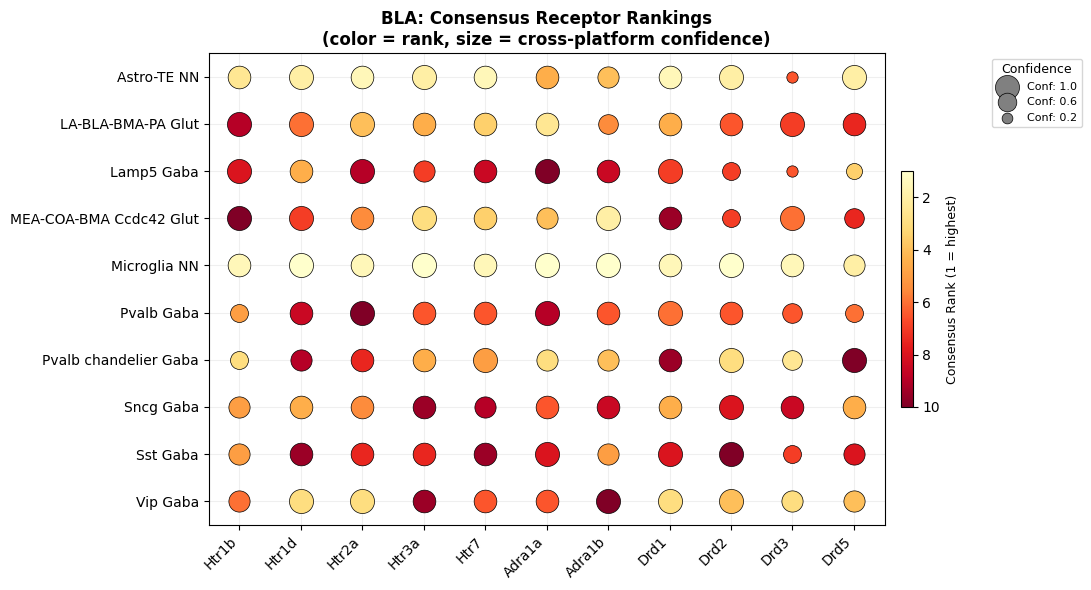

Saved: consensus_rankings_BLA.png


In [14]:
def plot_consensus_dotplot(consensus, confidence, genes, region, filename):
    """Dot plot of consensus rankings with confidence sizing."""
    cell_types = consensus.index.tolist()
    n_ct = len(cell_types)
    n_genes = len(genes)
    
    fig, ax = plt.subplots(figsize=(max(10, n_genes * 1.0), max(6, n_ct * 0.45)))
    
    for i, ct in enumerate(cell_types):
        for j, gene in enumerate(genes):
            rank_val = consensus.loc[ct, gene]
            conf_val = confidence.loc[ct, gene]
            
            # Size: confidence (0-1) mapped to dot size
            size = max(20, conf_val * 300)
            # Color: rank (1=dark/top, N=light/bottom)
            color_val = 1 - (rank_val - 1) / (n_ct - 1)  # normalize to 0-1
            
            ax.scatter(j, i, s=size, c=[plt.cm.YlOrRd(color_val)],
                      edgecolors='black', linewidth=0.5, zorder=3)
    
    ax.set_xticks(range(n_genes))
    ax.set_xticklabels(genes, rotation=45, ha='right', fontsize=10)
    ax.set_yticks(range(n_ct))
    ax.set_yticklabels(cell_types, fontsize=10)
    ax.set_xlim(-0.5, n_genes - 0.5)
    ax.set_ylim(-0.5, n_ct - 0.5)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.2)
    
    ax.set_title(f'{region}: Consensus Receptor Rankings\n'
                 f'(color = rank, size = cross-platform confidence)',
                 fontweight='bold', fontsize=12)
    
    # Legends
    # Size legend
    for conf_val, label in [(1.0, '1.0'), (0.6, '0.6'), (0.2, '0.2')]:
        ax.scatter([], [], s=max(20, conf_val * 300), c='grey', edgecolors='black',
                  linewidth=0.5, label=f'Conf: {label}')
    # Color legend
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=1, vmax=n_ct))
    cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.02)
    cbar.set_label('Consensus Rank (1 = highest)', fontsize=9)
    cbar.ax.invert_yaxis()
    
    ax.legend(loc='upper left', bbox_to_anchor=(1.15, 1.0), title='Confidence',
              fontsize=8, title_fontsize=9)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {filename}')

plot_consensus_dotplot(bla_consensus, bla_confidence, shared_genes, 'BLA',
                       'consensus_rankings_BLA.png')

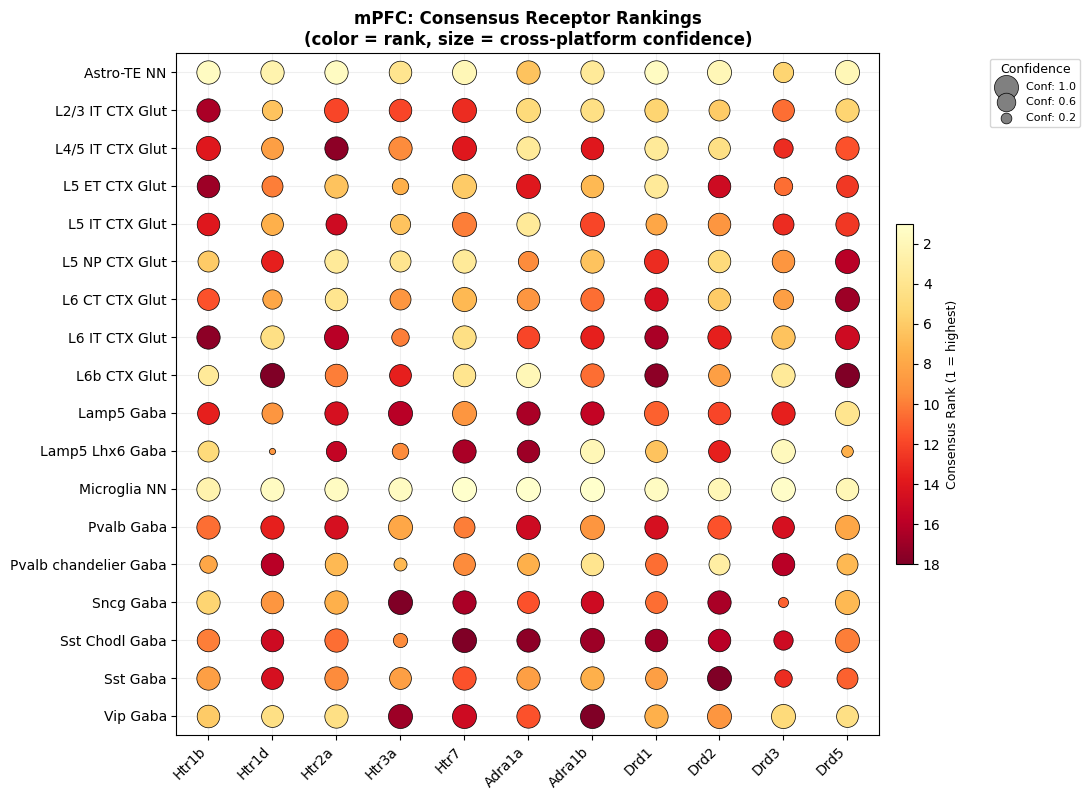

Saved: consensus_rankings_mPFC.png


In [15]:
plot_consensus_dotplot(mpfc_consensus, mpfc_confidence, shared_genes, 'mPFC',
                       'consensus_rankings_mPFC.png')

## 10. Save Consensus Rankings to CSV

In [16]:
# Combine and save
all_rankings = pd.concat([bla_summary, mpfc_summary])
all_rankings.to_csv('consensus_receptor_rankings.csv', index=False)

print(f'Saved consensus_receptor_rankings.csv: {len(all_rankings)} rows')
print(f'  BLA: {len(bla_summary)} entries ({len(bla_shared_sc)} cell types x {len(shared_genes)} genes)')
print(f'  mPFC: {len(mpfc_summary)} entries ({len(mpfc_shared_sc)} cell types x {len(shared_genes)} genes)')
print(f'\nColumns: {list(all_rankings.columns)}')

# Show high-confidence top-ranked entries
print(f'\n{"=" * 80}')
print('High-confidence top-3 rankings (confidence >= 0.7, consensus rank <= 3.0)')
print(f'{"=" * 80}')
top = all_rankings[(all_rankings['confidence'] >= 0.7) & (all_rankings['consensus_rank'] <= 3.0)]
top_sorted = top.sort_values(['region', 'gene', 'consensus_rank'])
display(top_sorted[['region', 'gene', 'cell_type', 'consensus_rank',
                     'rank_10x', 'rank_merfish', 'confidence']].reset_index(drop=True))

Saved consensus_receptor_rankings.csv: 308 rows
  BLA: 110 entries (10 cell types x 11 genes)
  mPFC: 198 entries (18 cell types x 11 genes)

Columns: ['region', 'gene', 'cell_type', 'consensus_rank', 'rank_10x', 'rank_merfish', 'rank_diff', 'confidence']

High-confidence top-3 rankings (confidence >= 0.7, consensus rank <= 3.0)


,region,gene,cell_type,consensus_rank,rank_10x,rank_merfish,confidence
0,BLA,Adra1a,Lamp5 Gaba,1.0,1,1,1.000000
1,BLA,Adra1a,Pvalb Gaba,2.0,2,2,1.000000
2,BLA,Adra1a,Sst Gaba,3.0,3,3,1.000000
3,BLA,Adra1b,Vip Gaba,1.0,1,1,1.000000
4,BLA,Adra1b,Lamp5 Gaba,2.5,3,2,0.888889
5,BLA,Adra1b,Sncg Gaba,2.5,2,3,0.888889
6,BLA,Drd1,MEA-COA-BMA Ccdc42 Glut,1.5,1,2,0.888889
7,BLA,Drd1,Pvalb chandelier Gaba,1.5,2,1,0.888889
8,BLA,Drd1,Sst Gaba,3.0,3,3,1.000000
9,BLA,Drd2,Sst Gaba,1.0,1,1,1.000000
